In [1]:
import sys
import pathlib
from os import uname
import json

import numpy as np
import ROOT as rt
from math import ceil, floor
import numba as nb

from src.muon_system import MuonSystemAwkward
from src import CMS_lumi, tdrstyle
from src.helper_functions import alert, Table  # , canvas
from src.histo_utilities import create_TH1D, create_TH2D, create_TGraph, std_color_list

from histo_skim import (
    create_hists,
    ROOT_ERROR_LEVEL,
    DATA_VERSION,
    LUMI,
    FN_MC,
    FN_R3,
    T2_OUT_DIR,
    T2_DATA_DIR,
    LOCAL_OUT_DIR,
    LOCAL_DATA_DIR,
    OUT_DIR,
    DATA_DIR,
    gc,
    ABCD_DTSIZE,
    ABCD_DPHI,
    TOP_MARGIN,
    BOT_MARGIN,
    CUTS,
)

# from sklearn.metrics import roc_auc_score  # , roc_curve
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import GradientBoostingClassifier  # , RandomForestClassifier

# **************************** #
if "TIER2" in DATA_DIR:
    OUT_DIR = f"{T2_OUT_DIR}/{OUT_DIR}"

    FN_MC = f"{T2_DATA_DIR}/MC_Summer22EE/v1/sixie/v{DATA_VERSION}/normalized/{FN_R3}.root"
    FN_R3 = f"{T2_DATA_DIR}/Data2022/v{DATA_VERSION}/normalized/{FN_R3}.root"

    FN_HLT_MC = f"{LOCAL_DATA_DIR}/../processed/mc_hlt569.root" #! BROKEN
    FN_HLT_R3 = f"{LOCAL_DATA_DIR}/../processed/r3_hlt569.root" #! BROKEN
else:
    OUT_DIR = f"{LOCAL_OUT_DIR}/{OUT_DIR}"

    FN_MC = f"{LOCAL_DATA_DIR}/{FN_MC}_v{DATA_VERSION}.root"
    FN_R3 = f"{LOCAL_DATA_DIR}/{FN_R3}_v{DATA_VERSION}.root"

    FN_HLT_MC = f"{LOCAL_DATA_DIR}/../processed/mc_hlt569.root"
    FN_HLT_R3 = f"{LOCAL_DATA_DIR}/../processed/r3_hlt569.root"

pathlib.Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
# **************************** #
rt.gErrorIgnoreLevel = ROOT_ERROR_LEVEL
# rt.gROOT.SetBatch(True)
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0
# **************************** #

Welcome to JupyROOT 6.30/02


In [72]:
N_EVENTS = -1
CUTS = [
    "match",
    "HLT", #! Loading TBranch HLTDecision causes memory overflow so I use second precut TTree
    # "CSC&DT>0",
    "L1",
    "CSCIT",
    "DTIT",
    "MET",
    # "ME11/12",
    # "MB1",
    "JET",
    # "MUON",
    # "BDT",
    "HALO",
    # "CSCSIZE",
    "DTSTN",
    "1CSC1DT",
    # "BLINDSR",
    # "DR",
    "DPHI",
]

if "HLT" in CUTS:
    ff_mc, ff_r3 = FN_MC, FN_HLT_R3
else:
    ff_mc, ff_r3 = FN_MC, FN_R3

# **** #

ms_mc = MuonSystemAwkward(ff_mc, tree_name="MuonSystem", name="Signal", nev=N_EVENTS, is_mc=True, lumi=LUMI)
ms_r3_dtit = MuonSystemAwkward(ff_r3, tree_name="MuonSystem_HLT569", name="Data", nev=N_EVENTS, is_mc=False, lumi=LUMI)
# ms_r3_dtit = MuonSystemAwkward(ff_r3, tree_name="MuonSystem_HLT569", name="Data, DT IT", nev=N_EVENTS, is_mc=False, lumi=LUMI)
# ms_r3_dtoot = MuonSystemAwkward(ff_r3, tree_name="MuonSystem_HLT569", name="Data, DT OOT", nev=N_EVENTS, is_mc=False, lumi=LUMI)

# ms_mc = MuonSystemAwkward(FN_MC, name="Signal, Muon Vetoes", nev=N_EVENTS, is_mc=True, lumi=LUMI)
# ms_r3_other = MuonSystemAwkward(FN_R3, name="Data, DT IT + Muon Vetoes", nev=N_EVENTS, is_mc=False, lumi=LUMI)
# ms_mc = MuonSystemAwkward(FN_MC, name="Signal, Jet Vetoes", nev=N_EVENTS, is_mc=True, lumi=LUMI)
# ms_r3_other = MuonSystemAwkward(FN_R3, name="Data, DT IT + Jet Vetoes", nev=N_EVENTS, is_mc=False, lumi=LUMI)

mss = [ms_mc, ms_r3_dtit]
# mss = [ms_mc, ms_r3_dtoot]
# mss = [ms_mc, ms_r3_dtit, ms_r3_dtoot]

# **** #
print("")
names = [ms.name for ms in mss]
for ims, ms in enumerate(mss):
    # !!! #
    ms.cut = False
    # !!! #
    msn, is_mc = ms.name.lower(), ms.is_mc
    for cut in CUTS:
        match cut:
            case "match":
                if is_mc:
                    ms.match_mc("csc,dt", has_clusters=True)
            case "HLT":
                # if not is_mc:
                #     ms.cut_hlt()
                pass  #! Loading TBranch HLTDecision causes memory overflow so I use a precut TTree
            case "CSC&DT>0":
                ms.f((ms["nCsc"] > 0) & (ms["nDt"] > 0))
            case "L1":
                ms.cut_l1()
            case "CSCIT":
                ms.cut_time("csc", invert="csc oot" in msn)
            case "DTIT":
                ms.cut_time("dt", invert="dt oot" in msn)
            case "MET":
                ms.f((0 <= ms["met"]) & (ms["met"] < 200))
            case "ME11/12":
                ms.f(
                    ms["cscNRechitChamberPlus11"]
                    + ms["cscNRechitChamberMinus11"]
                    + ms["cscNRechitChamberPlus12"]
                    + ms["cscNRechitChamberMinus12"]
                    == 0,
                    "csc",
                )
            case "MB1":
                ms.f(ms["dtNHitStation1"] < 10, "dt")
            case "JET":
                # ms.cut_jet("csc,dt")
                ms.cut_jet("csc,dt")#, csc_pt=150, dt_pt=10)
                # ms.cut_jet("dt")
            case "MUON":
                ms.cut_muon("csc,dt")
            case "BDT":
                pass
            case "HALO":
                ms.cut_halo(invert=False)  #! HALO CUT
            case "CSCSIZE":
                # ms.f(ms["cscSize"] > 250, "csc")
                ms.f(ms["cscSize"] > 200, "csc")
            case "DTSIZE":
                ms.f(ms["dtSize"] < 200, "dt")
            case "CSCSTN":
                ms.f(ms["cscSize"] > 250, "csc")
            case "DTSTN":
                ms.f((ms["dtNStation10"] < 3) & ~((ms["dtNStation10"] == 2) & (ms["dtMaxStation"] == 4)), "dt")
            case "1CSC1DT":
                ms.tag(tags="cscdt")
            case "BLINDSR":
                if not is_mc:
                    ms.f((ms["dtSize"] < ABCD_DTSIZE) | (ms["tag_dPhi"] < ABCD_DPHI), "dt")
            case "DR":
                ms.f(ms["tag_dR"] > 0.5)
            case "DPHI":
                ms.f(ms["tag_dPhi"] > 0.4, invert=False)

    # !!! #
    ms.cut = True
    # !!! #

    ms.colors = [std_color_list[ims], std_color_list[len(mss) + ims]]
    print(f"{ms.name:>{max([len(n) for n in names])}} : {ms.count():,.1f} events")

# **** #
weights = [np.asarray(ms["weight"]) for ms in mss]
colors = [ms.colors[0] for ms in mss]
blind_conds = [
    np.ones_like(ms["tag_dPhi"], dtype=bool) if ms.is_mc else (ms["dtSize"][:, 0] < ABCD_DTSIZE) | (ms["tag_dPhi"] < ABCD_DPHI)
    for ms in mss
]

Building MuonSystemAwkward 'Signal' -
  is_mc  = True
  events = -1
  tree   = 'MuonSystem'
  file   = '/home/psimmerl/mds_analysis/data/raw/ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_13p6TeV_1pb_weighted_v6.root'
  Extracted 1,851,400 events
Building MuonSystemAwkward 'Data' -
  is_mc  = False
  events = -1
  tree   = 'MuonSystem_HLT569'
  file   = '/home/psimmerl/mds_analysis/data/raw/../processed/r3_hlt569.root'
  Extracted 1,038,214 events

Signal : 2,122.2 events
  Data : 142.0 events


In [73]:
print("min", np.min(mss[0]["met"]), np.min(mss[1]["met"]))
print("max", np.max(mss[0]["met"]), np.max(mss[1]["met"]))
print("median", np.median(mss[0]["met"]), np.median(mss[1]["met"]))
print("mean", np.mean(mss[0]["met"]), np.mean(mss[1]["met"]))
print("std", np.std(mss[0]["met"]), np.std(mss[1]["met"]))
print()

print(np.quantile(mss[0]["met"], [0.1 * i for i in range(1, 10)]))
print(np.quantile(mss[1]["met"], [0.1 * i for i in range(1, 10)]))
print()

print(np.quantile(mss[0]["met"], [1 - (0.01)**(i/10) for i in range(1, 10)]))
print(np.quantile(mss[1]["met"], [1 - (0.01)**(i/10) for i in range(1, 10)]))

min 0.3576166 3.8369687


max 197.69502 139.55916
median 39.74224 30.924706
mean 48.21371512951893 33.63132702464789
std 33.18195816569581 20.21201935321721

[14.7, 21.5, 27.5, 33.6, 39.7, 47.6, 57.3, 70, 91.8]
[10.6, 16.6, 22.6, 26.2, 30.9, 34.4, 40.6, 47.7, 59.4]

[31.9, 47.7, 62.9, 76.8, 91.8, 108, 124, 137, 150]
[25.2, 34.5, 45, 50.1, 59.4, 63.3, 68.7, 73, 81.6]


In [74]:
met = mss[0]["met"]
# start, end = np.log10(np.quantile(met, 0.0)), np.log10(np.quantile(met, 0.99))
# mids = np.logspace(start, end, 10, endpoint=True)
# start, end = 10**start, 10**end

# start, end = np.quantile(met, 0.005), np.quantile(met, 0.995)
# mids = np.linspace(start, end, 10, endpoint=True)
# mids_str = "[" + ", ".join([f"{x:.2f}" for x in mids]) +"]"
# print(f"{start=:.2f}, {end=:.2f}")
# print(f"{mids_str=}")
# print(f"{sum(met < start)=}, {sum(met > end)=}")

start, end = 0.01, 0.999
mids = np.quantile(met, np.linspace(start, end, 10, endpoint=True))
# start, end = np.log10(start), np.log10(end)
# mids = np.quantile(met, np.logspace(start, end, endpoint=True))
# start, end = 10**start, 10**end
start, end = mids[0], mids[-1]
mids_str = "[" + ", ".join([f"{x:.2f}" for x in mids]) +"]"
print(f"{start=:.2f}, {end=:.2f}")
print(f"{mids_str=}")
print(f"{sum(met < start)=}, {sum(met > end)=}")
print()


start=5.34, end=194.44
mids_str='[5.34, 16.28, 23.18, 29.99, 36.56, 44.68, 54.20, 66.87, 88.26, 194.44]'
sum(met < start)=36, sum(met > end)=4



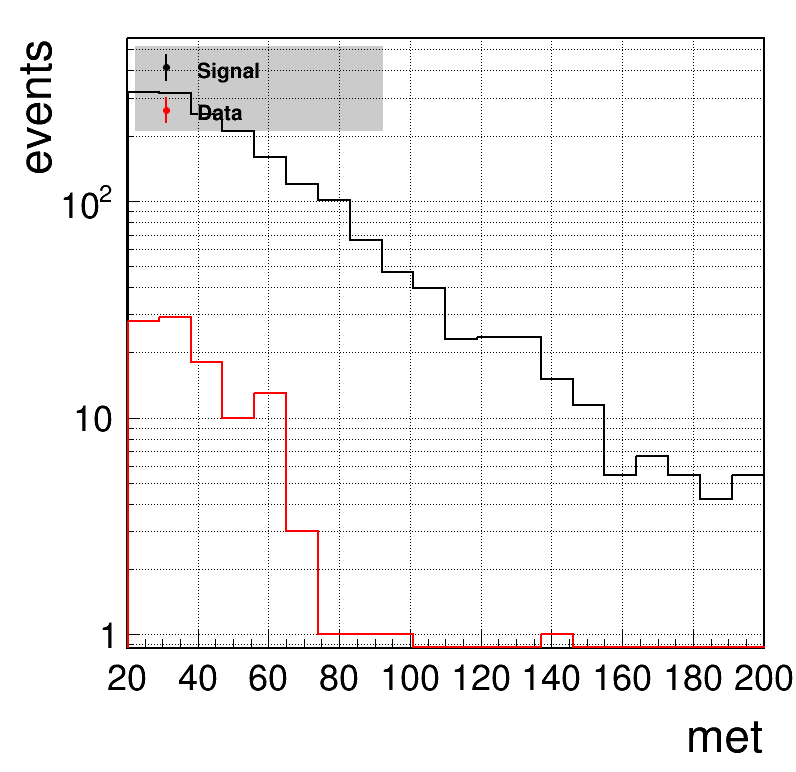

In [75]:
bins, log, norm = [20,20, 200], True, False
axis_titles = ["met", f"{'fraction of ' if norm else ''}events"]
values = [ms["met"] for ms in mss]

_v, _n, _w, _c = values, names, weights, colors
canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)
canvas.Draw()

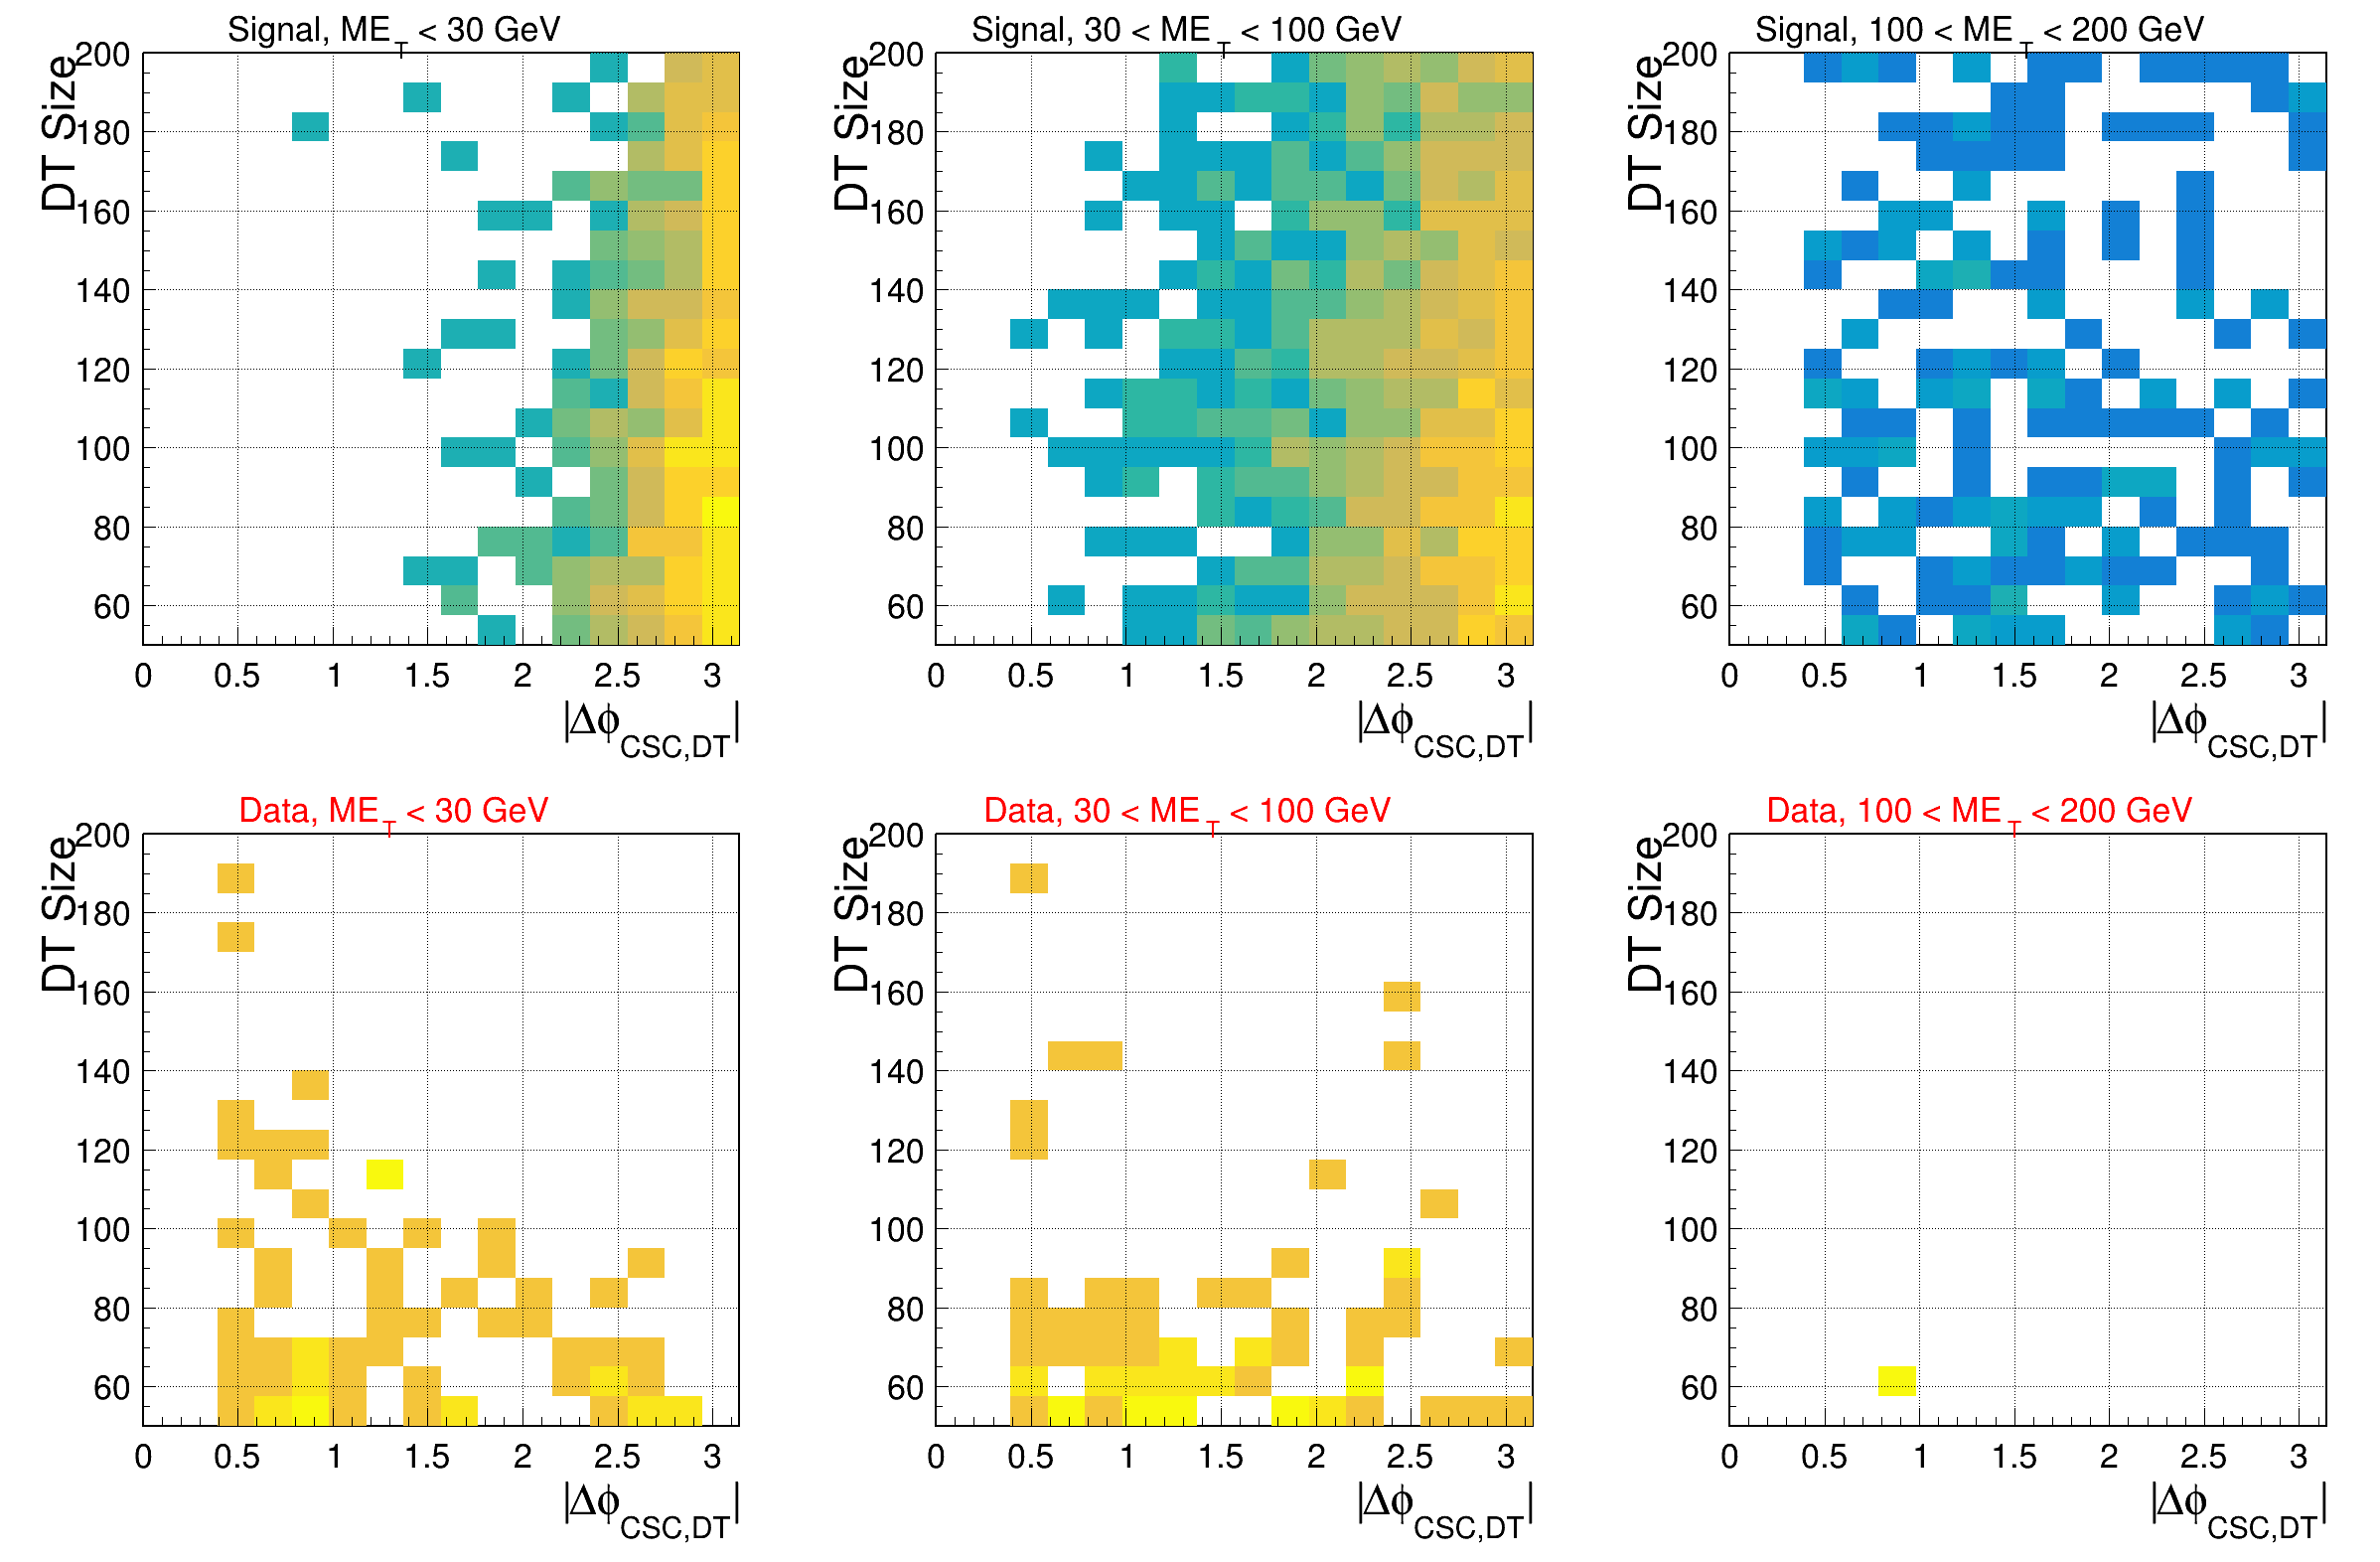

In [76]:
canvas = rt.TCanvas('','',3*800,2*800)
canvas.Divide(3, 2)

# _v = [np.c_[ms['tag_dPhi'], ms['dtSize']] for ms in mss]
bins, log, norm = [16, 0, np.pi, 20, 50, 200], False, True
axis_titles = ["|#Delta#phi_{CSC,DT}|", "DT Size", f"{'fraction of ' if norm else ''}events"]
_n = names

_v1 = [np.c_[ms['tag_dPhi'][ (0 < ms['met']) & (ms['met'] < 30) ],
             ms['dtSize'][ (0 < ms['met']) & (ms['met'] < 30) ]] for ms in mss]
_v2 = [np.c_[ms['tag_dPhi'][ (30 < ms['met']) & (ms['met'] < 100) ],
             ms['dtSize'][ (30 < ms['met']) & (ms['met'] < 100) ]] for ms in mss]
_v3 = [np.c_[ms['tag_dPhi'][ (100 < ms['met']) & (ms['met'] < 200) ],
             ms['dtSize'][ (100 < ms['met']) & (ms['met'] < 200) ]] for ms in mss]

_n1 = ['Signal, ME_{T} < 30 GeV', 'Data, ME_{T} < 30 GeV']
_n2 = ['Signal, 30 < ME_{T} < 100 GeV', 'Data, 30 < ME_{T} < 100 GeV']
_n3 = ['Signal, 100 < ME_{T} < 200 GeV', 'Data, 100 < ME_{T} < 200 GeV']

_, _, hs1 = create_hists(_v1, bins, _n1, axis_titles, _w, _c, styles=None, log=log, norm=norm)
_, _, hs2 = create_hists(_v2, bins, _n2, axis_titles, _w, _c, styles=None, log=log, norm=norm)
_, _, hs3 = create_hists(_v3, bins, _n3, axis_titles, _w, _c, styles=None, log=log, norm=norm)

lat = rt.TLatex()
lat.SetTextAlign(23)
for ihs, hs in enumerate([hs1, hs2, hs3]):
    for ih, h in enumerate(hs):
        canvas.cd(ihs + 3*ih + 1)
        canvas.cd(ihs + 3*ih + 1).SetGrid()
        canvas.cd(ihs + 3*ih + 1).SetRightMargin(0.04)
        canvas.cd(ihs + 3*ih + 1).SetLogz()
        h.Draw("col")
        lat.SetTextColor(h.GetLineColor())
        lat.DrawLatexNDC(0.5, 1, h.GetName().split(".")[0])

canvas.Draw()

/home/psimmerl/.conda/envs/pyroot/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/psimmerl/.conda/envs/pyroot/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


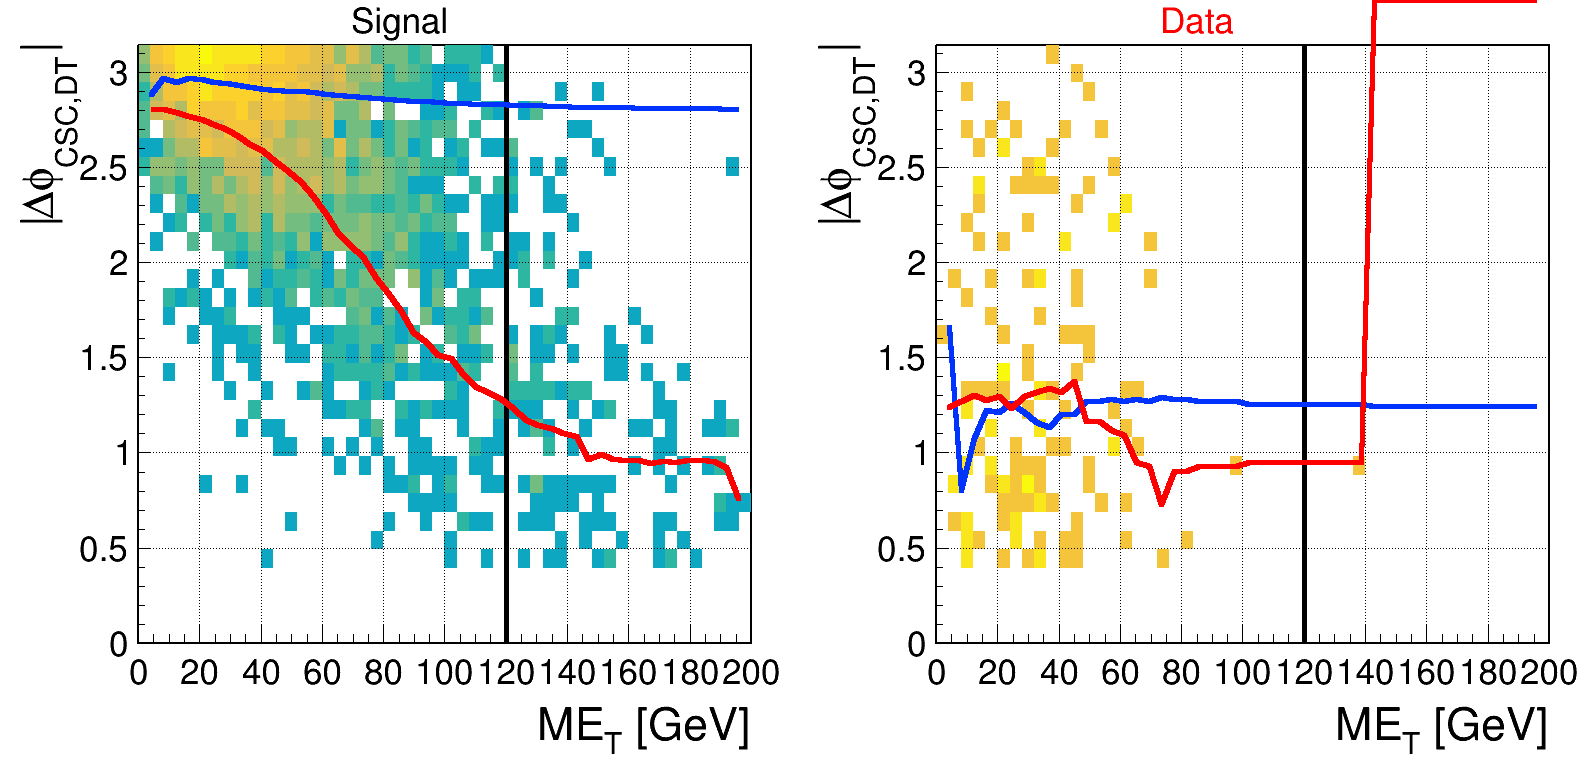

In [77]:
# canvas = rt.TCanvas('','',3*800,2*800)
# canvas = rt.TCanvas('','',800,800)
# canvas.Divide(3, 2)

bins, log, norm = [50, 0, 200,32, 0, np.pi], False, True
axis_titles = ['ME_{T} [GeV]', '|#Delta#phi_{CSC,DT}|', f'{"fraction of " if norm else ""}events']
_n = names

_v = [np.c_[ms['met'],ms['tag_dPhi']] for ms in mss]
canvas, _, hs = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)


cutoff = np.linspace(0, 200, 50)
_vg_l = [ np.array([np.median(v[v[:,0]<co,1]) for co in cutoff]) for v in _v]
_vg_h = [ np.array([np.median(v[v[:,0]>co,1]) for co in cutoff]) for v in _v]

gr_mc_l = rt.TGraph(len(cutoff)-2, cutoff[1:-1]*1., _vg_l[0][1:-1]*1.)
gr_mc_h = rt.TGraph(len(cutoff)-2, cutoff[1:-1]*1., _vg_h[0][1:-1]*1.)
gr_r3_l = rt.TGraph(len(cutoff)-2, cutoff[1:-1]*1., _vg_l[1][1:-1]*1.)
gr_r3_h = rt.TGraph(len(cutoff)-2, cutoff[1:-1]*1., _vg_h[1][1:-1]*1.)

gr_mc_l.SetLineWidth(5)
gr_r3_l.SetLineWidth(5)
gr_mc_l.SetLineColor(rt.kAzure)
gr_r3_l.SetLineColor(rt.kAzure)

gr_mc_h.SetLineWidth(5)
gr_r3_h.SetLineWidth(5)
gr_mc_h.SetLineColor(rt.kRed)
gr_r3_h.SetLineColor(rt.kRed)


lat = rt.TLatex()
lat.SetTextAlign(23)
for ih, h in enumerate(hs):
    canvas.cd(ih + 1)
    canvas.cd(ih + 1).SetGrid()
    canvas.cd(ih + 1).SetRightMargin(0.04)
    canvas.cd(ih + 1).SetLogz()
    h.Draw("col")
    lat.SetTextColor(h.GetLineColor())
    lat.DrawLatexNDC(0.5, 1, h.GetName().split(".")[0])

    line = rt.TLine(120, 0, 120, np.pi)
    line.SetLineWidth(5)
    line.SetLineColor(rt.kBlack)
    line.Draw()
    gc.append(line)

    if ih == 0:
        gr_mc_l.Draw('same')
        gr_mc_h.Draw('same')
    if ih == 1:
        gr_r3_l.Draw('same')
        gr_r3_h.Draw('same')
canvas.Draw()

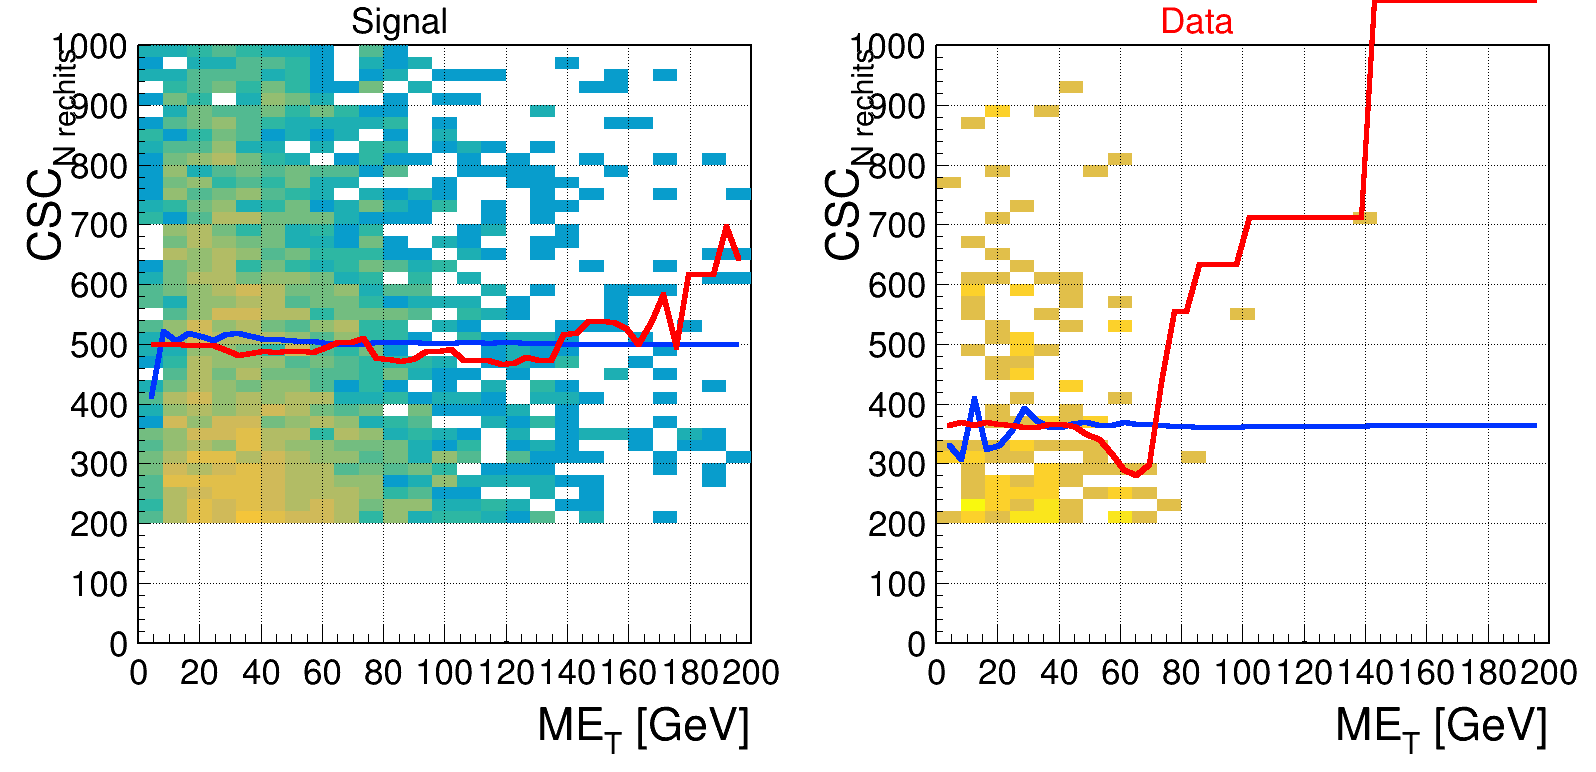

In [78]:
# canvas = rt.TCanvas('','',3*800,2*800)
# canvas = rt.TCanvas('','',800,800)
# canvas.Divide(3, 2)

bins, log, norm = [25, 0, 200, 50, 0, 1000], False, True
axis_titles = ['ME_{T} [GeV]', 'CSC_{N rechits}', f'{"fraction of " if norm else ""}events']
_n = names

_v = [np.c_[ms['met'],ms['cscSize']] for ms in mss]
canvas, _, hs = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)


cutoff = np.linspace(0, 200, 50)
_vg_l = [ np.array([np.median(v[v[:,0]<co,1]) for co in cutoff]) for v in _v]
_vg_h = [ np.array([np.median(v[v[:,0]>co,1]) for co in cutoff]) for v in _v]

gr_mc_l = rt.TGraph(len(cutoff)-2, cutoff[1:-1]*1., _vg_l[0][1:-1]*1.)
gr_mc_h = rt.TGraph(len(cutoff)-2, cutoff[1:-1]*1., _vg_h[0][1:-1]*1.)
gr_r3_l = rt.TGraph(len(cutoff)-2, cutoff[1:-1]*1., _vg_l[1][1:-1]*1.)
gr_r3_h = rt.TGraph(len(cutoff)-2, cutoff[1:-1]*1., _vg_h[1][1:-1]*1.)

gr_mc_l.SetLineWidth(5)
gr_r3_l.SetLineWidth(5)
gr_mc_l.SetLineColor(rt.kAzure)
gr_r3_l.SetLineColor(rt.kAzure)

gr_mc_h.SetLineWidth(5)
gr_r3_h.SetLineWidth(5)
gr_mc_h.SetLineColor(rt.kRed)
gr_r3_h.SetLineColor(rt.kRed)


lat = rt.TLatex()
lat.SetTextAlign(23)
for ih, h in enumerate(hs):
    canvas.cd(ih + 1)
    canvas.cd(ih + 1).SetGrid()
    canvas.cd(ih + 1).SetRightMargin(0.04)
    canvas.cd(ih + 1).SetLogz()
    h.Draw("col")
    lat.SetTextColor(h.GetLineColor())
    lat.DrawLatexNDC(0.5, 1, h.GetName().split(".")[0])

    line = rt.TLine(120, 0, 120, np.pi)
    line.SetLineWidth(5)
    line.SetLineColor(rt.kBlack)
    line.Draw()
    gc.append(line)

    if ih == 0:
        gr_mc_l.Draw('same')
        gr_mc_h.Draw('same')
    if ih == 1:
        gr_r3_l.Draw('same')
        gr_r3_h.Draw('same')
canvas.Draw()

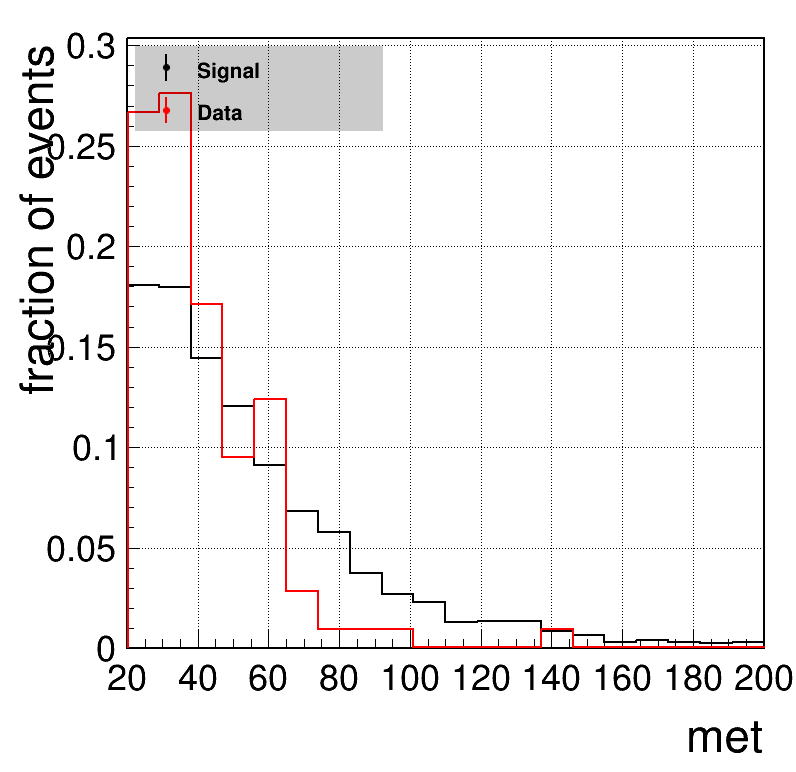

In [79]:
bins, log, norm = [20,20, 200], False, True
axis_titles = ["met", f"{'fraction of ' if norm else ''}events"]
values = [ms["met"] for ms in mss]

_v, _n, _w, _c = values, names, weights, colors
canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)
canvas.Draw()

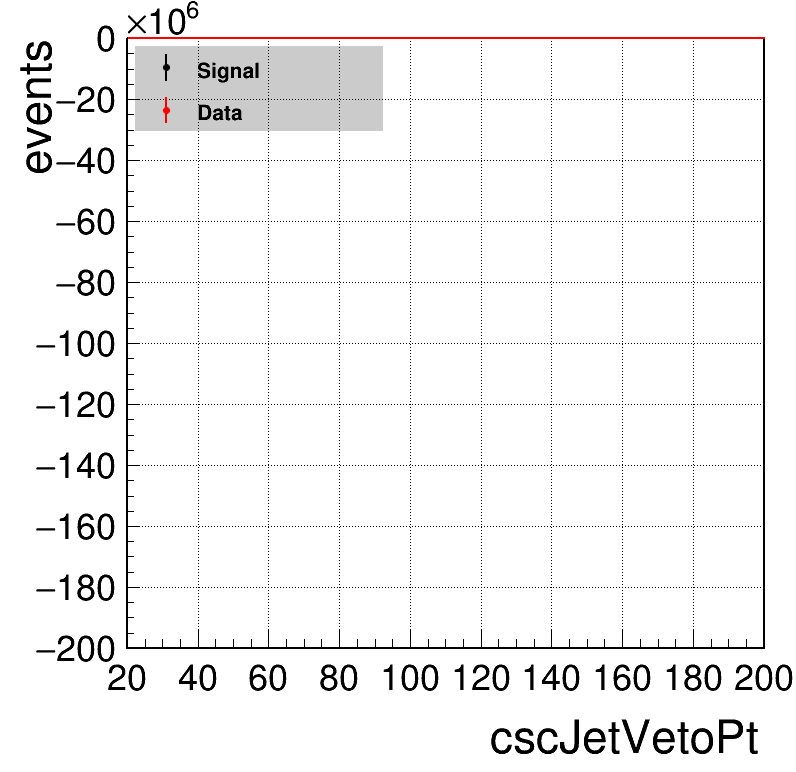

In [80]:
# bins, log, norm = [20,0, 5], False, True
# axis_titles = ["|dR_{CSC,DT}|", f"{'fraction of ' if norm else ''}events"]
# values = [ms["tag_dR"] for ms in mss]

# _v, _n, _w, _c = values, names, weights, colors
# canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)
# canvas.Draw()

# # nbins = int(np.sqrt(mss[-1].count()))
# # bins, log, norm = [nbins, 0, np.pi, nbins,0, 5], False, True
# # # bins, log, norm = [10, 0, np.pi, 10,0, 5], False, True
# # axis_titles = ["|d#phi_{CSC,DT}|", "|dR_{CSC,DT}|", f"{'fraction of ' if norm else ''}events"]
# # values = [np.c_[ms["tag_dR"],ms["tag_dPhi"]] for ms in mss]

# # _v, _n, _w, _c = values, names, weights, colors
# # canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)
# # canvas.Draw()

################################ 

# bins, log, norm = [20,20, 200], False, False
# axis_titles = ["cscJetVetoPt", f"{'fraction of ' if norm else ''}events"]
# values = [ms["cscJetVetoPt"] for ms in mss]

# _v, _n, _w, _c = values, names, weights, colors
# canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)
# canvas.Draw()

##################################

bins, log, norm = [20,20, 200], False, False
axis_titles = ["cscJetVetoPt", f"{'fraction of ' if norm else ''}events"]
values = [ms["cscJetVetoPt"] for ms in mss]

_v, _n, _w, _c = values, names, weights, colors
canvas, legend, hists = create_hists(_v, bins, _n, axis_titles, _w, _c, styles=None, log=log, norm=norm)
canvas.Draw()

In [81]:
mids = np.arange(0, 200, 5)
mids = [25, 50, 75, 100, 150, 200, 250]
sl_yields = [np.sum(mss[0]["weight"][(0<mss[0]["met"])&(mss[0]["met"]<mid)]) for mid in mids]
su_yields = [np.sum(mss[0]["weight"][(mid<mss[0]["met"])&(mss[0]["met"]<9999)]) for mid in mids]

bl_yields = [np.sum(mss[1]["weight"][(0<mss[1]["met"])&(mss[1]["met"]<mid)]) for mid in mids]
bu_yields = [np.sum(mss[1]["weight"][(mid<mss[1]["met"])&(mss[1]["met"]<9999)]) for mid in mids]


print(f"| MET | Sig < MET | Sig > MET | Bkg < MET | Bkg > MET | ")
print(f"| --- | --------- | --------- | --------- | --------- |")
for mid, sl, su, bl, bu in zip(mids, sl_yields, su_yields, bl_yields, bu_yields):
    print(f"| {mid:>3} |    {sl:>6.2f} |    {su:>6.2f} |    {bl:>6.2f} |    {bu:>6.2f} | ")

| MET | Sig < MET | Sig > MET | Bkg < MET | Bkg > MET | 
| --- | --------- | --------- | --------- | --------- |
|  25 |    550.33 |    1571.86 |     52.00 |     90.00 | 
|  50 |    1329.60 |    792.56 |    118.00 |     24.00 | 
|  75 |    1760.95 |    361.25 |    138.00 |      4.00 | 
| 100 |    1953.66 |    168.54 |    141.00 |      1.00 | 
| 150 |    2088.98 |     33.22 |    142.00 |      0.00 | 
| 200 |    2122.20 |      0.00 |    142.00 |      0.00 | 
| 250 |    2122.20 |      0.00 |    142.00 |      0.00 | 
